## Add Library

In [1]:
!git clone https://github.com/amirhosein-prdv/handwritten-Persian-numbers-recognition.git

Cloning into 'handwritten-Persian-numbers-recognition'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 72 (delta 14), reused 57 (delta 7), pack-reused 0
Receiving objects: 100% (72/72), 13.03 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, Adadelta

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import pickle
import random
import time
import zipfile
from shutil import copyfile
from sklearn.model_selection import train_test_split

*italicized text*## Add dataset

### Read HODA Dataset

In [6]:
# Hoda Dataset Reader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [107]:
dataset_path = "/content/handwritten-Persian-numbers-recognition/Data/Hoda Dataset"
# size of images
image_size = 40

### Load trainand test dataset

In [108]:
# load train images
train_images, train_labels = read_hoda_dataset(dataset_path=dataset_path+"/Train 60000.cdb",
                                images_height=image_size,
                                images_width=image_size,
                                one_hot=False,
                                reshape=True)

In [109]:
# load test images
X_test, y_test = read_hoda_dataset(dataset_path=dataset_path+"/Test 20000.cdb",
                                images_height=image_size,
                                images_width=image_size,
                                one_hot=False,
                                reshape=True)

In [110]:
# make val dataset
test_images, val_images, test_labels, val_labels = train_test_split(
    X_test.astype(np.float32), y_test, test_size=0.25, random_state=1234)

In [95]:
# shape of train, test and validation dataset respectively
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(60000, 1600)
(15000, 1600)
(5000, 1600)


In [111]:
# reshape images to the required size
train_images = train_images.reshape(train_images.shape[0], image_size, image_size)
val_images = val_images.reshape(val_images.shape[0], image_size, image_size)
test_images = test_images.reshape(test_images.shape[0], image_size, image_size)

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = np.copy(image)
    num_salt = int(salt_prob * image.size)
    num_pepper = int(pepper_prob * image.size)

    # Add Salt
    salt_coords = [np.random.randint(0, i, num_salt) for i in image.shape]
    noisy_image[tuple(salt_coords)] = 1

    # Add Pepper
    pepper_coords = [np.random.randint(0, i, num_pepper) for i in image.shape]
    noisy_image[tuple(pepper_coords)] = 0

    return noisy_image

def add_noise_to_borders(image, margin=3, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the borders of the image with a specified margin."""
    noisy_image = np.copy(image)
    rows, cols = image.shape

    # Top border
    for i in range(margin):
        noisy_image[i, :] = add_salt_and_pepper_noise(noisy_image[i, :], salt_prob, pepper_prob)

    # Bottom border
    for i in range(1, margin + 1):
        noisy_image[-i, :] = add_salt_and_pepper_noise(noisy_image[-i, :], salt_prob, pepper_prob)

    # Left and right borders
    for i in range(margin, rows - margin):
        noisy_image[i, :margin] = add_salt_and_pepper_noise(noisy_image[i, :margin], salt_prob, pepper_prob)
        noisy_image[i, -margin:] = add_salt_and_pepper_noise(noisy_image[i, -margin:], salt_prob, pepper_prob)

    return noisy_image

def add_noise_to_dataset(images, margin=3, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the borders of each image in the dataset."""
    final_noisy_images = []
    for image in images:
        noisy_image = add_noise_to_borders(image, margin, salt_prob, pepper_prob)
        final_noisy_images.append(noisy_image)

    final_noisy_images = np.array(final_noisy_images)
    return np.concatenate((images, final_noisy_images), axis=0)

# Assuming your images are normalized to [0, 1]
train_images = np.random.rand(60000, 40, 40)  # Replace with your actual data
test_images = np.random.rand(15000, 40, 40)  # Replace with your actual data
val_images = np.random.rand(5000, 40, 40)  # Replace with your actual data

# Add noise to datasets
train_images_noisy = add_noise_to_dataset(train_images)
test_images_noisy = add_noise_to_dataset(test_images)
val_images_noisy = add_noise_to_dataset(val_images)

print("New training set shape:", train_images_noisy.shape)
print("New test set shape:", test_images_noisy.shape)
print("New validation set shape:", val_images_noisy.shape)

# Update the original datasets
train_images = train_images_noisy
test_images = test_images_noisy
val_images = val_images_noisy

print("Updated training set shape:", train_images.shape)
print("Updated test set shape:", test_images.shape)
print("Updated validation set shape:", val_images.shape)

# Visualize some images to verify the noise
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {i}")
plt.show()


KeyboardInterrupt: 

### Show dataset sample

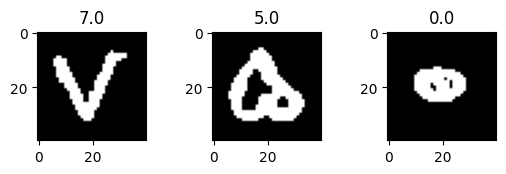

In [97]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

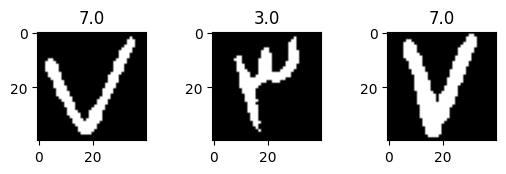

In [15]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(test_labels[i])

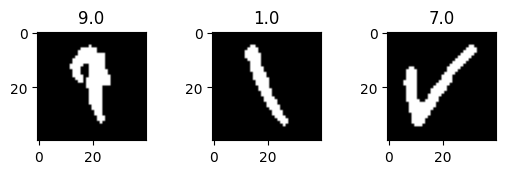

In [16]:
#val samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(val_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(val_labels[i])

## Preprocessing data

In [112]:
def preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val):

    # reshape images to the required size
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)



    # convert image values from integers to floats
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_val = X_val.astype('float32')



    # normalization
#     X_train = X_train/255.0
#     X_test = X_test/255.0
#     X_test = X_val/255.0


    # One-hot encoding label
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_val = to_categorical(y_val)


    return X_train, y_train, X_test, y_test, X_val, y_val

## Define Model

In [113]:
def DCNN():
    model = Sequential()

    # Input layer
    model.add(Input(shape=(image_size, image_size,1)))

    # Convolutional Block 1
    model.add(Conv2D(64, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.1))

    # Convolutional Block 2
    model.add(Conv2D(128, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.2))

    # Convolutional Block 3
    model.add(Conv2D(256, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.3))

    # Convolutional Block 4
    model.add(Conv2D(512, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.4))

    # Classification Block
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # The output layer
    model.add(Dense(10, activation='softmax'))


    # Optimizer

    opt = SGD(momentum=0.9) # Momentum optimizer
#     opt = Adam() # Adam optimizer
#     opt = Adadelta() # Adadelta optimizer


    model.compile(loss = 'categorical_crossentropy',
                    optimizer = opt,
                    metrics = ['accuracy'])
    return model

optimization = 'Adam'

In [114]:
DCNN_model = DCNN()
DCNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 40, 40, 64)        640       
                                                                 
 activation_21 (Activation)  (None, 40, 40, 64)        0         
                                                                 
 batch_normalization_24 (Ba  (None, 40, 40, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 19, 19, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 19, 19, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 19, 19, 128)      

## Training model

In [115]:
def train_model(model, X_train, y_train, X_test, y_test, X_val, y_val, epochs = 25, batch_size = 64):

    # Preprocess all training and testing data
    X_train, y_train, X_test, y_test, X_val, y_val= preprocess_data(X_train, y_train,
                                                                  X_test, y_test,
                                                                  X_val, y_val)

    # Callbacks
    tensorboard_callback = TensorBoard(log_dir=f"./logs_{optimization}")
    model_checkpoint_callback = ModelCheckpoint(filepath=f"./checkpoint_{optimization}",
                                                verbose=1,
                                                save_best_only=True,
#                                                 save_weights_only=True,
                                                monitor='val_accuracy',
                                                mode='max'
                                               )
    earlyStopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max',)

    # Fitting the model on the training set
    history = model.fit(X_train, y_train,
                        epochs = epochs,
                        batch_size = batch_size,
                        steps_per_epoch = X_train.shape[0]//batch_size,
                        validation_data = (X_val,y_val),
                        callbacks = [tensorboard_callback, model_checkpoint_callback, earlyStopping_callback]
                       )


    # evaluating the model
    print("\n\nmodel evaluation :")
    _, acc = model.evaluate(X_val, y_val, verbose = 1)
    print('validation accuracy : %.3f' % (acc * 100.0))

    return history

In [33]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(60000, 40, 40)
(15000, 40, 40)
(5000, 40, 40)


In [ ]:
history = train_model(DCNN_model, train_images, train_labels, test_images, test_labels, val_images, val_labels)

Epoch 1/25
937/937 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9618
Epoch 1: val_accuracy improved from -inf to 0.98720, saving model to ./checkpoint_Adam
937/937 [==============================] - 35s 34ms/step - loss: 0.1317 - accuracy: 0.9618 - val_loss: 0.0471 - val_accuracy: 0.9872
Epoch 2/25
937/937 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9911
Epoch 2: val_accuracy improved from 0.98720 to 0.99080, saving model to ./checkpoint_Adam
937/937 [==============================] - 33s 35ms/step - loss: 0.0323 - accuracy: 0.9911 - val_loss: 0.0297 - val_accuracy: 0.9908
Epoch 3/25
937/937 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9941
Epoch 3: val_accuracy improved from 0.99080 to 0.99280, saving model to ./checkpoint_Adam
937/937 [==============================] - 33s 35ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0258 - val_accuracy: 0.9928
Epoch 4/25
937/937 [==========================

### Plot of accuracy

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(history.history['accuracy'], color = 'blue', label = 'train_acc')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

### Plot of loss

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], color = 'blue', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'val_loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
with open(f'./logs_{optimization}/{optimization}.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Test

In [ ]:
DCNN_model = tf.keras.models.load_model(f"./checkpoint_{optimization}")

In [ ]:
# load test images
X_test, y_test = read_hoda_dataset(dataset_path=dataset_path+"/Test 20000.cdb",
                                images_height=image_size,
                                images_width=image_size,
                                one_hot=False,
                                reshape=True)

X_test = X_test.reshape(-1, image_size, image_size, 1)
print(X_test.shape)

In [ ]:
y_pred = DCNN_model.predict(X_test, verbose=1)

625/625 [==============================] - 3s 5ms/step


In [ ]:
y_pred = np.array([np.argmax(vector) for vector in (y_pred>=0.5)])

### Percision, Recall, F1 Score, Confusion matrix

In [ ]:
print('Percision Score : {}\n'.format(precision_score(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')))
print('Recall Score : {}\n'.format(recall_score(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')))
print('F1 Score : {}\n'.format(f1_score(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')))
print('Confusion Matrix : \n\n{}'.format(confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])))

Percision Score : 0.99595

Recall Score : 0.99595

F1 Score : 0.99595

Confusion Matrix : 

[[1994    0    0    0    2    4    0    0    0    0]
 [   2 1994    2    0    0    0    0    0    0    2]
 [   0    1 1981   12    5    0    0    0    0    1]
 [   0    0    5 1988    7    0    0    0    0    0]
 [   0    0    2    3 1994    1    0    0    0    0]
 [   4    0    0    0    2 1994    0    0    0    0]
 [   0    2    1    0    1    4 1987    0    0    5]
 [   1    1    1    0    0    0    1 1996    0    0]
 [   0    1    0    0    0    0    0    0 1998    1]
 [   1    5    0    0    0    1    0    0    0 1993]]


### Comparison between algorithms

In [ ]:
with open(f'./out 1/logs_SGD/SGD.pickle', 'rb') as handle:
    sgd_history = pickle.load(handle)

with open(f'./out 1/logs_Adam/Adam.pickle', 'rb') as handle:
    adam_history = pickle.load(handle)

with open(f'./out 1/logs_delta/delta.pickle', 'rb') as handle:
    adadelta_history = pickle.load(handle)

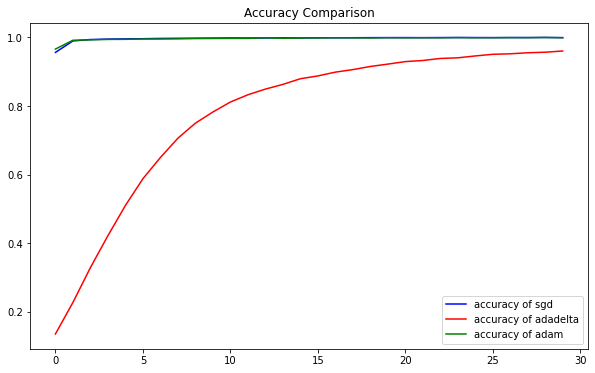

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(sgd_history['accuracy'], color = 'blue', label = 'accuracy of sgd')
plt.plot(adadelta_history['accuracy'], color = 'red', label = 'accuracy of adadelta')
plt.plot(adam_history['accuracy'], color = 'green', label = 'accuracy of adam')
plt.legend()
plt.title('Accuracy Comparison')
plt.show()